# Flat Fielding of Slitless Spectroscopy

## 0.  Primer
Slitless spectroscopy uses a dispersive and transmissive optical element in the collimated beam to create a complete spectroscopic view of any astrophysical scene.  However, the lack of any light-restricting aperture (such as a slitlet, fiber, etc.), means that the spectral trace of multiple sources may overlap in the two-dimensional grism image.  Therefore a given imaging pixel may record the flux (at different wavelengths) from the multiple sources and/or background components (such as Zodiacal background, thermal emission, etc.).  Here, we discuss the issues associated with extending the classical application of a flat-field image to correct for pixel-to-pixel variations in the imaging device to that of slitless spectroscopy.


This notebook was prepared by [Mehdi Rezaie](mailto:mr095415@ohio.edu) and [Russell Ryan](mailto:rryan@stsci.edu) as part of the Astrogrism coding spring May 11-16, 2020.  

## 1.  Review of Key Concepts



optical path of an imaging device may include physical obstructions (e.g. dust or particulates on optimal elements), illumination effects (e.g. vignetting), and/or variable pixel-to-pixel sensitivities, which leads to a nonuniform response. 


Since the sensitivity of a given pixel depends on the wavelength of incident light, the flat-field response must be characterized as a (${\cal F}(\lambda)$), and therefore the measured response in a given pixel $(x,y)$ is given as an integral:
$$
r_{x,y}  = \int {\cal F}_{x,y}(\lambda)\, f_{x,y}(\lambda)\,\mathrm{d}\lambda
\tag{1}
$$
where $f(\lambda)$ is the spectrum of the incident light.  





## 2.  Extensions to Slitless Spectroscopy

One key difference between a grism optical element and a standard imaging element is that light incident on a given pixel $(x_d,y_d)$ will be recorded a new pixel position $(x_g,y_g)$, where that remapping is done as a function of wavelength and $(x_d,y_d)$.  This process must be calibrated by standard observations, which often results in determining the spectral trace and dispersion solution.  Software has been developed by [Nor Prizkal and Russell Ryan](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-01.pdf) to implement these transformations, and are represented a parametric functions:


$$
x_g = \mathrm{X} (x_d,y_d,t) + x_d\\
y_g = \mathrm{Y} (x_d,y_d,t) + y_d\\
\lambda = \Lambda (x_d,y_d,t)
\tag{2}
$$

where $t$ is a parameter such that $0\leq t\leq1$.  With that, it is apparent that the response of a pixel (eq. 1) must be reconsidered as the incident spectrum effectively eminates from a different position:
$$
r_{x_g,y_g} = \int {\cal F}_{x_g,y_g}(\lambda)\,f_{x_d,y_d}(\lambda)\,\mathrm{d}\lambda.
\tag{3}
$$
***Note, here we take care to explicitly subscript $(x,y)$ with either $g$ or $d$ to refer to the measured position in a grism image or effective position from a direct image, respectively.***  Therefore, when flat-fielding one must invert the family of functions for $(x_g,y_g,\lambda)$ to account for the relevant spectral components (whether from astrophysical sources or background contributions).  



The flat-field image for slitless spectroscopy is often characterized as a polynomial in wavelength, where each of the polynomial coefficients is a two-dimensional image:
$$
{\cal F}_{x,y}(\lambda) = \sum_i {\cal F}_{x,y,i}\left(\frac{\lambda-\lambda_0}{\lambda_1-\lambda_0}\right)^i 
\tag{4}
$$
where $\lambda_0$ and $\lambda_1$ are arbitrary values that are often choosen to be approximately the blue and red edges (respectively) of the throughput of the grism element. In common usage, this is often referred to as a *flatfield cube*.  

Here is a schematic image of a flat field cube (shamelessly copied from Martin Kummel et al. slides)

![flat field](figures/flatfieldcube.png)

## 3.  Simplifying Examples



### 3.1 CRDS 
find the offset between flat field image and science image.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')
from src import DataLoader

In [2]:
# read data 
data = DataLoader('../inputs/icoi3immq_flt.fits')

In [3]:
data # .__repr__() will show what `data` is


  file: ../inputs/icoi3immq_flt.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      IMAGE_HDU       SCI[1]
  2      IMAGE_HDU       ERR[1]
  3      IMAGE_HDU       DQ[1]
  4      IMAGE_HDU       SAMP[1]
  5      IMAGE_HDU       TIME[1]

In [4]:
data.get_keyword('OSCNTAB') # this keyword will point us at the reference file

'iref$q911321mi_osc.fits'

In [5]:
science = data.read_ext(1) # you can read a given extension

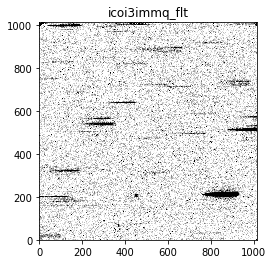

In [6]:
science.imshow(title='icoi3immq_flt')

### 3.2 Local ACS WFC data

In [3]:
g800l = DataLoader('../inputs/ACS_WFC_Grism_Data/G800L/jdql01jxq_flc.fits')
flat = DataLoader('../inputs/ACS_WFC_Grism_Data/CONF/WFC.flat.cube.CH1.2.fits')

In [4]:
g800l, flat

(
   file: ../inputs/ACS_WFC_Grism_Data/G800L/jdql01jxq_flc.fits
   mode: READONLY
   extnum hdutype         hduname[v]
   0      IMAGE_HDU       
   1      IMAGE_HDU       SCI[1]
   2      IMAGE_HDU       ERR[1]
   3      IMAGE_HDU       DQ[1]
   4      IMAGE_HDU       SCI[2]
   5      IMAGE_HDU       ERR[2]
   6      IMAGE_HDU       DQ[2]
   7      IMAGE_HDU       D2IMARR[1]
   8      IMAGE_HDU       D2IMARR[2]
   9      IMAGE_HDU       D2IMARR[3]
   10     IMAGE_HDU       D2IMARR[4]
   11     BINARY_TBL      WCSCORR[1],
 
   file: ../inputs/ACS_WFC_Grism_Data/CONF/WFC.flat.cube.CH1.2.fits
   mode: READONLY
   extnum hdutype         hduname[v]
   0      IMAGE_HDU       
   1      IMAGE_HDU       
   2      IMAGE_HDU       
   3      IMAGE_HDU       )

In [5]:
science1 = g800l.read_ext(1)
science2 = g800l.read_ext(4)

flats = [flat.read_ext(i) for i in range(0, 4)] 

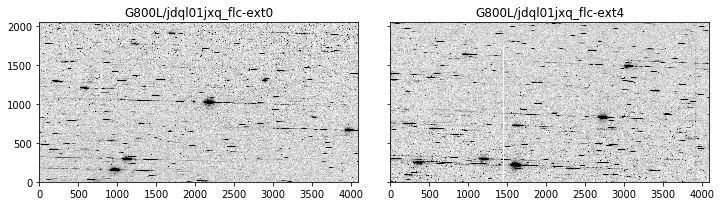

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
science1.imshow(ax[0], vmin=0, vmax=100, title='G800L/jdql01jxq_flc-ext0', hold=True)
science2.imshow(ax[1], vmin=0, vmax=100, title='G800L/jdql01jxq_flc-ext4')

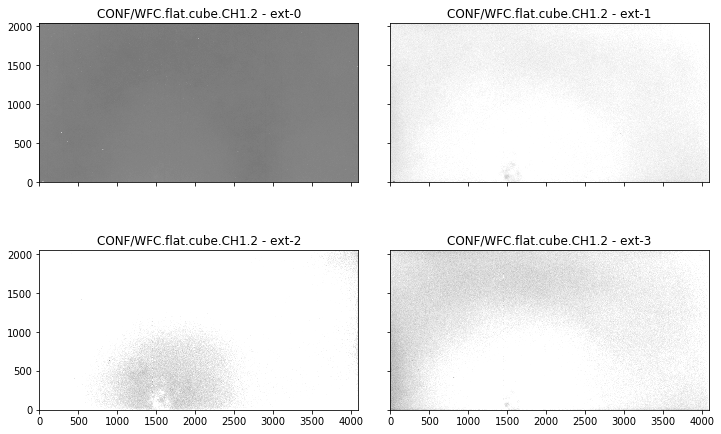

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=2, 
                       figsize=(12, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax.flatten()

for i, axi in enumerate(ax):
    flats[i].imshow(ax=axi, vmin=0, vmax=2, 
                    hold=True, title='CONF/WFC.flat.cube.CH1.2 - ext-%d'%i)

In [6]:
data.get_keyword('OSCNTAB')

'iref$q911321mi_osc.fits'

In [7]:
science = data.read_ext(1)

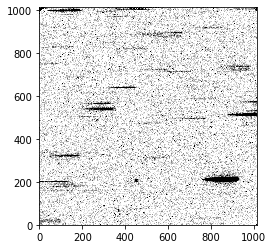

In [8]:
science.imshow(vmin=0, vmax=0.2, origin='lower', cmap=plt.cm.binary)

## 4.  Issues and Caveats


